This code is an advanced and comprehensive script designed for creating a synthetic dataset, importing a trained target convolutional neural network (CNN) for image processing, and then utilizing a large language model (LLM), here Mistral7b, for interpreting the CNN's output activations. The script is written in Python and heavily relies on PyTorch, a popular deep learning framework, and the Hugging Face `transformers` library. It involves several sophisticated techniques in machine learning and deep learning.

1. **Environment Setup**: The script begins by setting environment variables for CUDA (to specify GPU usage) and Hugging Face token and cache paths. This ensures that the GPU resources are correctly allocated and that the Hugging Face models are efficiently cached.

2. **Library Imports**: Various libraries are imported for handling data (like NumPy, Pandas), image processing (PIL), machine learning (PyTorch, transformers), and dataset management (Hugging Face datasets).

3. **Synthetic Image Generation**: Functions are defined to generate synthetic images with specific shapes (like lines, ellipses, checkerboards). These images serve as a controlled environment to understand how the CNN processes different shapes.

4. **Synthetic Image Generation**: Functions are defined to generate synthetic images with specific shapes (like lines, ellipses, checkerboards). These images serve as a controlled environment to understand how the CNN processes different shapes.

5. **Importing Manually Annotated image**: Moreover, we import already manually annotated images. Then, a custom target CNN model is defined, and its weights are loaded. This model will process the synthetic images to produce activation maps, which are essentially features extracted from the images.

6. **Image Processing and Data Preparation**: The script processes images through the CNN, flattening and storing the raw pixel data and activations. This processed data simulates what a CNN would 'see' as it analyzes an image.

7. **Dataset Creation and Management**: The script creates a synthetic dataset and a manually annotated dataset, encapsulating them in PyTorch's DataLoader for efficient batch processing.

8. **Model Preparation for Training**: The script prepares a large language model from the Hugging Face library, specifically configuring it for the task at hand. This involves setting device maps for distributed GPU training, enabling gradient checkpointing, and adapting the model with LoRA (Low-Rank Adaptation), a method to efficiently fine-tune large models.

9. **Data Tokenization**: The script tokenizes the processed image data to make it compatible with the language model. This involves converting the activation maps and image descriptions into a format understandable by the LLM.

10. **Training Setup**: A detailed training setup is created using Hugging Face's `Trainer` class. This setup includes specifying the training and evaluation datasets, batch sizes, learning rates, and logging configurations. Notably, the script uses advanced optimization techniques like 8-bit AdamW for memory-efficient training and enables mixed-precision training with FP16.

11. **Training Execution**: Finally, the training is executed. The script also includes a command to monitor GPU usage, indicating a high-performance computing environment.

#### Summary

The first part of the script is devoted to generating, analyzing and preparing a synthetic  and a human-annotated dataset which we use to fine-tune the LLM. Later, I implement tokenization and training Mistral 7b using 9 A40 GPUs for one/two days and save the model. Since I use methods like quantization and lora-adapters one could modify the code to reproduce the results here. Note that in order to load Mistral 7b one needs a huggingface account which is free

Load all the libraries we need. It's important to set CUDA_VISIBLE_DEVICES before importing PyTorch in the script because PyTorch initializes its CUDA subsystem as soon as it's imported. If one changes CUDA_VISIBLE_DEVICES after PyTorch has been imported, it won't have any effect because PyTorch has already initialized its CUDA environment and detected available GPUs.

In [ ]:
#General purpose
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7,8"

from datetime import datetime
import json
import random
import math
from PIL import Image
import pickle # For loading the human-annotated images

# General data libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#machine learning libs
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#some special machine learnings libs for our CNN and for data efficiency
from torchvision import datasets, transforms
from datasets import load_dataset

#Large language models and Fine tuning
import transformers
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig


# Libs for facilitating distributed training for our large language model

from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig
from accelerate import FullyShardedDataParallelPlugin, Accelerator

# We start a second thread to monitor GPU usage during training
import threading
import subprocess
import time



We check availability of GPUs for Training using nvidia-smi and also check if the cuda_visible_devices variable has been set correctly.

Check if my pytorch version is compatible with the cuda-version on the hardware that I use. On my training run my pytorch version was cuda 12.1 and the hardware version was cuda 12.2 ensuring good compatibility.

In [ ]:
print("CUDA Version from nvidia-smi: \n")  # Replace with the actual output
!nvidia-smi | grep "CUDA Version"
print(f"Number of GPUs and their usage \n ")
!nvidia-smi --query-gpu=index,name,memory.total,memory.used,utilization.gpu --format=csv

print("CUDA_VISIBLE_DEVICES set to:", os.environ.get("CUDA_VISIBLE_DEVICES"))


print("PyTorch version:", torch.__version__)
print("CUDA version PyTorch is built with:", torch.version.cuda)

CUDA Version from nvidia-smi: 

| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
Number of GPUs and their usage 
 
index, name, memory.total [MiB], memory.used [MiB], utilization.gpu [%]
0, NVIDIA A40, 46068 MiB, 7 MiB, 0 %
1, NVIDIA A40, 46068 MiB, 7 MiB, 0 %
2, NVIDIA A40, 46068 MiB, 7 MiB, 0 %
3, NVIDIA A40, 46068 MiB, 7 MiB, 0 %
4, NVIDIA A40, 46068 MiB, 7 MiB, 0 %
5, NVIDIA A40, 46068 MiB, 7 MiB, 0 %
6, NVIDIA A40, 46068 MiB, 7 MiB, 0 %
7, NVIDIA A40, 46068 MiB, 7 MiB, 0 %
8, NVIDIA A40, 46068 MiB, 7 MiB, 0 %
CUDA_VISIBLE_DEVICES set to: 0,1,2,3,4,5,6,7,8
PyTorch version: 2.1.1+cu121
CUDA version PyTorch is built with: 12.1


The following code is for generating our synthetic images. We first need to define functions that randomly generate shapes that resemble the primitive shapes in the MNIST data set. The shapes generated are verticals, horizontals, diagonals, contra-diagonals, ellipses, checkerboard patterns and crossings. The starting point, the length, and the shapes orientation in the plane are randomly generated within pre-determined bounds. Moreover, the total number of shapes is generated using an exponential distribution to favor lower count of shapes in order to prevent shape collusion.

In [ ]:
def generate_vertical_line_image(image, line_min_height=6, line_max_height=12):
    height, width = image.shape

    num_lines = 1
    for _ in range(num_lines):
        line_height = random.randint(line_min_height, line_max_height)
        line_start_x = random.randint(0, width - 1)
        line_start_y = random.randint(0, height - line_height)

        image[line_start_y:line_start_y + line_height, line_start_x] = 255

    return image

def generate_horizontal_line_image(image, line_min_length=6, line_max_length=12):
    height, width = image.shape

    num_lines = 1
    for _ in range(num_lines):
        line_length = random.randint(line_min_length, line_max_length)
        line_start_x = random.randint(0, width - line_length)
        line_start_y = random.randint(0, height - 1)

        image[line_start_y, line_start_x:line_start_x + line_length] = 255

    return image

def generate_contra_diagonal_line(image, line_min_length=4, line_max_length=12):
    height, width = image.shape

    # Determine line length
    line_length = random.randint(line_min_length, line_max_length)

    # Random start position for contra-diagonal line
    line_start_x = random.randint(0, width - line_length)
    line_start_y = random.randint(0, height - line_length)

    # Draw the contra-diagonal line
    for i in range(line_length):
        image[line_start_y + i, line_start_x + i] = 255

    return image

def generate_diagonal_line(image, line_min_length=4, line_max_length=12):
    height, width = image.shape

    # Determine line length
    line_length = random.randint(line_min_length, line_max_length)

    # Random start position for diagonal line
    line_start_x = random.randint(0, width - line_length)
    line_start_y = random.randint(line_length - 1, height - 1)

    # Draw the diagonal line
    for i in range(line_length):
        image[line_start_y - i, line_start_x + i] = 255

    return image



def add_crossing_to_image(image):
    def rotate_point(point, angle, origin=(0, 0)):
        """ Rotate a point around a given origin. """
        ox, oy = origin
        px, py = point

        qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
        qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
        return qx, qy

    def translate_point(point, dx, dy):
        """ Translate a point by dx and dy. """
        x, y = point
        return x + dx, y + dy

    def draw_line(image, start_point, end_point):
        """ Draw a straight line on the image, ensuring it stays within bounds. """
        x0, y0 = int(start_point[0]), int(start_point[1])
        x1, y1 = int(end_point[0]), int(end_point[1])
        dx = abs(x1 - x0)
        dy = abs(y1 - y0)
        sx = 1 if x0 < x1 else -1
        sy = 1 if y0 < y1 else -1
        err = dx - dy

        while True:
            if 0 <= x0 < image.shape[1] and 0 <= y0 < image.shape[0]:
                image[y0, x0] = 255  # Set pixel to white
            if (x0, y0) == (x1, y1):
                break
            e2 = 2 * err
            if e2 > -dy:
                err -= dy
                x0 += sx
            if e2 < dx:
                err += dx
                y0 += sy

    height, width = image.shape

    # Define the middle point and first line
    mid_point = (width // 2, height // 2)
    first_line_start = (mid_point[0], mid_point[1] - 3)
    first_line_end = (mid_point[0], mid_point[1] + 3)

    # Random rotation and translation for the first line
    rotation_angle = random.uniform(0, 2 * math.pi)  # Random rotation angle
    translation_dx = random.randint(-9, 9)  # Random translation in x
    translation_dy = random.randint(-9, 9)  # Random translation in y

    # Rotate and translate the first line
    rotated_start = rotate_point(first_line_start, rotation_angle, mid_point)
    rotated_end = rotate_point(first_line_end, rotation_angle, mid_point)
    translated_start = translate_point(rotated_start, translation_dx, translation_dy)
    translated_end = translate_point(rotated_end, translation_dx, translation_dy)

    # Draw the first line
    draw_line(image, translated_start, translated_end)

    # Define the second line
    second_line_mid_point = ((translated_start[0] + translated_end[0]) / 2, (translated_start[1] + translated_end[1]) / 2)
    second_line_length = 3  # Length of the second line

    # Calculate the second line's rotation angle with improved range
    second_line_rotation_angle = (rotation_angle + random.uniform(math.pi / 4 - math.pi / 7, math.pi / 4 + math.pi / 7)) % (2 * math.pi)

    # Calculate the second line's end points
    second_line_end_1 = (
        second_line_mid_point[0] + second_line_length * math.cos(second_line_rotation_angle),
        second_line_mid_point[1] + second_line_length * math.sin(second_line_rotation_angle)
    )
    second_line_end_2 = (
        second_line_mid_point[0] - second_line_length * math.cos(second_line_rotation_angle),
        second_line_mid_point[1] - second_line_length * math.sin(second_line_rotation_angle)
    )

    # Draw the second line
    draw_line(image, second_line_mid_point, second_line_end_1)
    draw_line(image, second_line_mid_point, second_line_end_2)

    return image


def add_checkerboard_pattern(image, grid_size=2, pattern_size=4):
    def draw_partial_checkerboard(image, grid_size, start, end):
        """ Draw a checkerboard pattern on a part of the image. """
        for y in range(start[1], end[1], grid_size):
            for x in range(start[0], end[0], grid_size):
                if (x // grid_size + y // grid_size) % 2 == 0:
                    image[y:y+grid_size, x:x+grid_size] = 255  # Set pixel to white

    def draw_random_checkerboard_5x5(image, grid_size, pattern_size):
        """ Draw a 5x5 checkerboard pattern at a random position in the image, considering the edges. """
        # Adjust the maximum size for a 5x5 checkerboard
        total_pattern_size = grid_size * pattern_size  # 5 squares of size 'grid_size' each

        # Randomly select the upper left corner within bounds
        max_x = image.shape[1] - total_pattern_size
        max_y = image.shape[0] - total_pattern_size
        start_x = random.randint(0, max_x)
        start_y = random.randint(0, max_y)

        # Define the region for the checkerboard pattern
        start_point = (start_x, start_y)
        end_point = (start_x + total_pattern_size, start_y + total_pattern_size)

        # Draw the checkerboard pattern
        draw_partial_checkerboard(image, grid_size, start_point, end_point)

    # Draw a 5x5 checkerboard pattern on the image
    draw_random_checkerboard_5x5(image, grid_size, pattern_size)
    return image


def add_corner_to_image(image):
    def draw_perpendicular_corner(image, point, corner_type):
        """ Draw a corner consisting of two 4-pixel lines that are perpendicular to each other. """
        x, y = point

        # Size of each line in the corner
        line_size = 3

        # Draw the corner based on the specified type
        if corner_type == 1:  # Upper Left
            image[y:y+line_size, x] = 255  # Vertical line
            image[y, x:x+line_size] = 255  # Horizontal line
        elif corner_type == 2:  # Upper Right
            image[y:y+line_size, x] = 255  # Vertical line
            image[y, x-line_size:x] = 255  # Horizontal line
        elif corner_type == 3:  # Bottom Left
            image[y-line_size:y +1 , x] = 255  # Vertical line
            image[y, x:x+line_size] = 255  # Horizontal line
        elif corner_type == 4:  # Bottom Right
            image[y-line_size:y +1, x] = 255  # Vertical line
            image[y, x-line_size:x] = 255  # Horizontal line

    # Randomly sample a point within a specific area to ensure space for the corner
    random_point = (random.randint(5, 22), random.randint(5, 22))

    # Randomly select a corner type
    corner_type = random.randint(1, 4)

    # Draw the perpendicular corner
    draw_perpendicular_corner(image, random_point, corner_type)

    return image



def draw_smooth_ellipse(image, center, axes, start_angle, end_angle, step=1):
    for angle in range(start_angle, end_angle, step):
        radian = math.radians(angle)
        x = center[0] + axes[0] * math.cos(radian)
        y = center[1] + axes[1] * math.sin(radian)

        # Apply anti-aliasing-like technique by softening the pixels near the ellipse boundary
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                ix, iy = int(x + dx), int(y + dy)
                if 0 <= ix < image.shape[1] and 0 <= iy < image.shape[0]:
                    distance = math.sqrt((x - ix) ** 2 + (y - iy) ** 2)
                    if distance < 1.5:  # Soften pixels close to the calculated point
                        image[iy, ix] = min(255, image[iy, ix] + int(255 * (1.5 - distance)))

def generate_partial_ellipse_image(image, num_ellipses=1):
    height, width = image.shape

    for _ in range(num_ellipses):
        center = (width // 2, height // 2)
        axes = (random.randint(8, 12), random.randint(8, 12))  # Adjust axes to avoid extremes
        angle_range = random.randint(50, 80)
        start_angle = random.randint(0, 360 - angle_range)
        end_angle = start_angle + angle_range

        draw_smooth_ellipse(image, center, axes, start_angle, end_angle)

    return image

def image_generator(num_corner = 0, num_vertical=0, num_horizontal=0, num_ellipse=0, num_diagonal=0, num_contra_diagonal= 0, num_crossing=0, num_checkerboard=0):
    # Initialize a 28x28 black image
    image = np.zeros((28, 28), dtype=np.uint8)

    # Add the specified number of vertical lines
    for _ in range(num_vertical):
        image = generate_vertical_line_image(image)

    # Add the specified number of vertical lines
    for _ in range(num_diagonal):
        image = generate_diagonal_line(image)

    # Add the specified number of vertical lines
    for _ in range(num_contra_diagonal):
        image = generate_contra_diagonal_line(image)


    # Add the specified number of horizontal lines
    for _ in range(num_horizontal):
        image = generate_horizontal_line_image(image)

    for _ in range(num_crossing):
        image = add_crossing_to_image(image)

    for _ in range(num_checkerboard):
        image = add_checkerboard_pattern(image)


    # Add the specified number of partial ellipses
    for _ in range(num_ellipse):
        image = generate_partial_ellipse_image(image)

    for _ in range(num_corner):
        image = add_corner_to_image(image)

    return image



We automatically annotate the synthetically generated image with an annotation that contains the total number of shape counts, and the number of shapes for each individual possible shape if this number is greater than zero.

In [ ]:
def sample_shape_count():
    # Sample using exponential distribution
    return int(np.random.exponential(scale=0.2) + 1)

def generate_shape_description(shape_counts):
    # Generate a human-readable description of the shapes
    descriptions = []
    for shape, count in shape_counts.items():
        if count > 0:
            shape_name = shape.split('_')[1]

            # Special handling for 'contra' shape
            if shape_name == 'contra':
                shape_name = 'contra diagonal'

            if count == 1:
                descriptions.append(f"1 {shape_name}")
            else:
                # Add 's' for plural, except for special case
                if shape_name == 'contra diagonal ':
                    descriptions.append(f"{count} {shape_name}")
                else:
                    descriptions.append(f"{count} {shape_name}s")
    return ', '.join(descriptions)


For the reader, we display some of those synthetic images and use the image's description for the title.

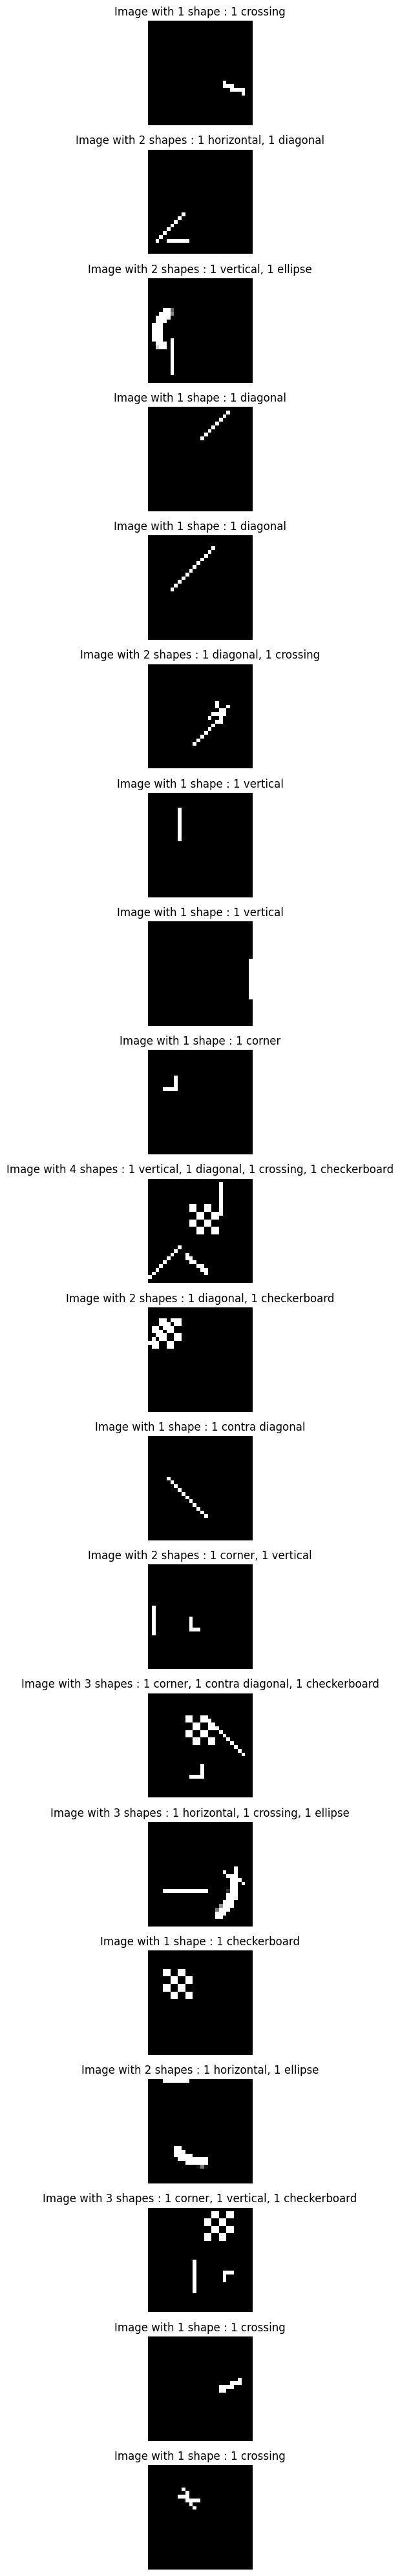

In [ ]:
def display_sampled_images_with_descriptions(num_images=20):
    # Set up the figure with one column and 'num_images' rows
    fig, axes = plt.subplots(num_images, 1, figsize=(5, num_images * 2))  # Adjust the size as needed

    if num_images == 1:
        axes = [axes]  # If only one image, put it in a list to make iterable

    for i, ax in enumerate(axes):
        shape_counts = {
            "num_corner": 0,
            "num_vertical": 0,
            "num_horizontal": 0,
            "num_diagonal": 0,
            "num_contra_diagonal": 0,
            "num_crossing": 0,
            "num_checkerboard": 0,
            "num_ellipse": 0
        }
        probabilities = [0.4, 0.3, 0.2, 0.1]
        num_shapes_to_select = np.random.choice([1, 2, 3, 4], p=probabilities)
        selected_shapes = np.random.choice(list(shape_counts.keys()), size=num_shapes_to_select, replace=False)
        for shape in selected_shapes:
            shape_counts[shape] = int(round(sample_shape_count()))

        generated_image = image_generator(**shape_counts)
        shape_description = generate_shape_description(shape_counts)
        total_shapes = sum(shape_counts.values())

        # Display the image
        ax.imshow(generated_image, cmap='gray')
        ax.axis('off')  # Hide the axis

        # Place the description below the image
        ax.set_title(f"Image with {total_shapes} shape{'s' if total_shapes > 1 else ''} : {shape_description}")

    plt.tight_layout()
    plt.show()

# Run the function to display sampled images with descriptions
display_sampled_images_with_descriptions(num_images=20)

In another script we have loaded a 100 MNIST images and manually annotated these images with the primitive shapes they contain similarly to the synthetic images. We load these images and their annotations and display one of them for illustration.

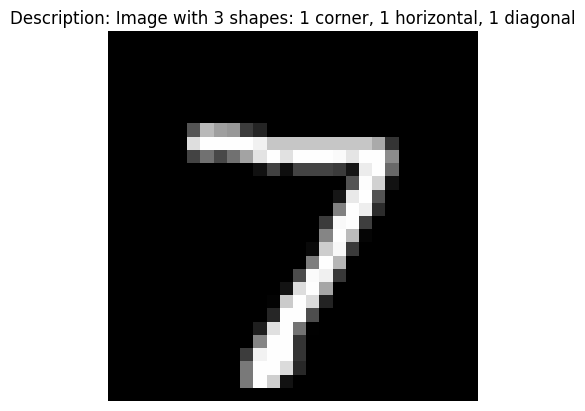

In [ ]:
# Load the processed images and annotations from the files
with open('first_100_testset_images.pkl', 'rb') as file:
    loaded_images = pickle.load(file)
with open('first_100_testset_manual_annotations.pkl', 'rb') as file:
    loaded_annotations = pickle.load(file)

# Display the first image and its annotation
first_image = np.squeeze(loaded_images[0])  # Remove the single-dimensional entry from the shape
plt.imshow(first_image, cmap='gray')
plt.axis('off')
plt.title(f"Description: {loaded_annotations[0]}")
plt.show()

Here, generate the synthetic data set. consisting of a list of images and their respective descriptions.

In [ ]:
def create_synthetic_dataset(num_images):
    # Create directory to save images and descriptions
    images = []
    descriptions = []

    for i in range(num_images):
        shape_counts = {
            "num_corner": 0,
            "num_vertical": 0,
            "num_horizontal": 0,
            "num_diagonal": 0,
            "num_contra_diagonal": 0,
            "num_crossing": 0,
            "num_checkerboard": 0,
            "num_ellipse": 0
        }
        probabilities = [0.4, 0.3, 0.2, 0.1]
        num_shapes_to_select = np.random.choice([1, 2, 3, 4], p=probabilities)
        selected_shapes = np.random.choice(list(shape_counts.keys()), size=num_shapes_to_select, replace=False)
        for shape in selected_shapes:
            shape_counts[shape] = int(round(sample_shape_count()))

        generated_image = image_generator(**shape_counts)
        shape_description = generate_shape_description(shape_counts)

        total_shapes = sum(shape_counts.values())


        shape_description = f"Image with {total_shapes} shape{'s' if total_shapes > 1 else ''}: {shape_description}"

        # Store the image and description
        images.append(generated_image)
        descriptions.append(shape_description)

    return images, descriptions


For efficiency and clarity we subclass the Dataset class and create a custom class that holds the initial synthetically generated images and their descriptions. We use transforms to normalize the synthetic images and make them appear similar to the training data with which the target neural network was trained.  

In [ ]:
class SyntheticDataset(Dataset):
    def __init__(self, images, descriptions, transform=None):
        self.images = images
        self.descriptions = descriptions
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        description = self.descriptions[idx]

        if self.transform:
            # Convert numpy array to tensor and apply transform
            #transforms.ToTensor is a constructor that creates an instance of the ToTensor transform.
            image = transforms.ToTensor()(image)
            image = self.transform(image)

        return image, description

Similarly to the synthetic dataset we subclass the dataset class for the manually annotated data and ensure that the images are normalized using the same paramers as with the synthetic data. Moreover, we analyze one instance of the images for debugging.

In [ ]:
class ManuallyAnnotatedDataset(Dataset):
    def __init__(self, images, descriptions, transform=None):
        self.images = images
        self.descriptions = descriptions
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        description = self.descriptions[idx]

        if self.transform:
            # Assuming the images are numpy arrays and need to be converted to tensors
            image = self.transform(image)

        return image, description

# Apply the same normalization transform as in the synthetic dataset
transform = transforms.Normalize((0.5,), (0.5,))

manuallyAnnotatedDataSet = ManuallyAnnotatedDataset(loaded_images, loaded_annotations, transform=transform)
manual_loader = DataLoader(manuallyAnnotatedDataSet, batch_size=1, shuffle=False)

# Example: Display the first image and its annotation from the manually annotated dataset
image, description = next(iter(manual_loader))
image_np = image.squeeze().numpy()  # Convert the image tensor to a numpy array for plotting
print(f"Shape of the annotated image tensor: {image.shape}")

# Print the raw image data as a numpy array
print("Raw image data (as numpy array) to ensure that they are normalized using transform:")
print(image)

# Print the description
print(description)


Shape of the annotated image tensor: torch.Size([1, 1, 28, 28])
Raw image data (as numpy array) to ensure that they are normalized using transform:
tensor([[[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000

We analyse here the synthetic data set.

We perform the same debugging for a synthetic image as well.

Shape of the image tensor: torch.Size([1, 1, 28, 28])
Raw image data (as numpy array):
tensor([[[[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
          [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
           -1., -

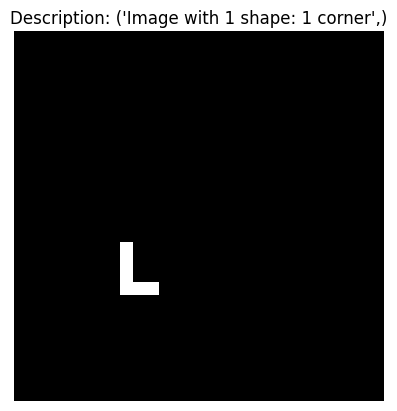

In [ ]:
images, descriptions = create_synthetic_dataset(num_images=1)
transform = transforms.Normalize((0.5,), (0.5,))
syntheticDataSet = SyntheticDataset(images, descriptions, transform=transform)
synth_loader = DataLoader(syntheticDataSet, batch_size=1, shuffle=False)

# Display one image and its corresponding description
image, description = next(iter(synth_loader))

# The image shape should be [1, 1, 28, 28] at this point
print(f"Shape of the image tensor: {image.shape}")

print("Raw image data (as numpy array):")
print(image)

print(description)
# Convert the image tensor to a numpy array for plotting
image_np = image.squeeze().numpy()

# Display the image and the description
plt.imshow(image_np, cmap='gray')
plt.title(f"Description: {description}")
plt.axis('off')
plt.show()

The neural network defined below is the target CNN that our interpreter aims to understand.

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Initialize convolutional layer 1 with He Initialization
        # Increased kernel size to 9 and number of filters remains 8
        self.conv1 = self._init_conv_layer(1, 8, 9, 1, 4, 'he')  # Padding adjusted to 4

        # Initialize convolutional layer 2 with He Initialization
        # Increased kernel size to 9 and number of filters remains 16
        self.conv2 = self._init_conv_layer(8, 16, 9, 1, 4, 'he')  # Padding adjusted to 4

        # Initialize fully connected output layer
        # Input dimension remains the same
        self.out = nn.Linear(16 * 7 * 7, 10)
        nn.init.kaiming_normal_(self.out.weight, nonlinearity='relu')

    def _init_conv_layer(self, in_channels, out_channels, kernel_size, stride, padding, init_method):
        """Initializes a convolutional layer followed by a ReLU activation and MaxPool."""
        layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        if init_method == 'he':
            nn.init.kaiming_normal_(layer[0].weight, nonlinearity='relu')

        return layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        output = self.out(x)
        return output, x


We show that our target CNN can accurately predict the labels in the MNIST data set after loading the weights which we obtained by training the target CNN on the MNIST data.

In [ ]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_traindataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnist_trainloader = DataLoader(mnist_traindataset, batch_size=1, shuffle=False)  # batch_size=1 to load images one by one

mnist_testDataSet = datasets.MNIST(root='./data', train=False, transform=transform)
mnist_testloader = DataLoader(mnist_testDataSet, batch_size=128, shuffle=False)

targetCNN = CNN()
weights = torch.load('mnistTwoLayersFilterSize9And16Filters.pth')
targetCNN.load_state_dict(weights)
# Test the CNN
targetCNN.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in mnist_testloader:
        outputs, _ = targetCNN(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy of the targetCNN: {test_accuracy}%')


Test Accuracy of the targetCNN: 98.85%


We analyze the shape of the synthetic images and also the shape of their activations after passing the synthetic data through the target CNN

In [ ]:
sample_data, _ = next(iter(synth_loader))
print("Shape of raw pixel data of synthetically generated data:", sample_data.shape)

# Get the shape of the activations from the first convolutional layer
activations = targetCNN.conv1(sample_data)
print("Shape of activations from the first convolutional layer for synthetic data:", activations.shape)

sample_dataMNIST, _ = next(iter(manual_loader))
print("Shape of raw pixel data of manually annotated MNIST image:", sample_dataMNIST.shape)

# Get the shape of the activations from the first convolutional layer
activations = targetCNN.conv1(sample_dataMNIST)
print("Shape of activations from the first convolutional layer for manually annotated MNIST image:", activations.shape)

Shape of raw pixel data of synthetically generated data: torch.Size([1, 1, 28, 28])
Shape of activations from the first convolutional layer for synthetic data: torch.Size([1, 8, 14, 14])
Shape of raw pixel data of manually annotated MNIST image: torch.Size([1, 1, 28, 28])
Shape of activations from the first convolutional layer for manually annotated MNIST image: torch.Size([1, 8, 14, 14])


The pipeline in this code cell goes like this: We create synthetic images and load the manually annotated images, then we wrap them into a data set class and extract them one by one using the data loader. We pass the synthectic image through the target neural network and store the flattened activations together with the descriptions. We do this in order to get a self-contained function that can generate the synthetic and manual data again and again. Note that the first entries of the dict are the synthetic data and the last the manually annotated data. This is why we analyze the first and the 105th entry so that we debug both datasets.

In [ ]:
def process_image(targetCNN, image, description):
    instance_data = {}
    # Process the image through the first convolutional layer
    with torch.no_grad():
        activations = targetCNN.conv1(image)

    # Flatten, and store raw pixel data and activations
    flattened_image = image.view(-1).numpy()
    instance_data['raw_pixel_data'] = flattened_image
    for j in range(8):  # Assuming 8 filters in the first conv layer
        flattened_activation = activations[0, j].flatten().numpy()
        instance_data[f'activationmap{j+1}'] = flattened_activation

    # Store image description
    instance_data['image_description'] = description
    return instance_data

#num_images defines the synthetic images.
def create_data_dict(targetCNN, num_images):
    # Assuming create_synthetic_dataset and SyntheticDataset are defined elsewhere
    images, descriptions = create_synthetic_dataset(num_images)
    transform = transforms.Normalize((0.5,), (0.5,))
    syntheticDataSet = SyntheticDataset(images, descriptions, transform=transform)
    synth_loader = DataLoader(syntheticDataSet, batch_size=1, shuffle=False)

    # File paths for manually annotated data (set within the function)
    manual_images_file = 'first_100_testset_images.pkl'
    manual_annotations_file = 'first_100_testset_manual_annotations.pkl'

    # Load manually annotated data
    with open(manual_images_file, 'rb') as file:
        loaded_images = pickle.load(file)
    with open(manual_annotations_file, 'rb') as file:
        loaded_annotations = pickle.load(file)

    # Assuming ManuallyAnnotatedDataset is defined elsewhere
    manuallyAnnotatedDataSet = ManuallyAnnotatedDataset(loaded_images, loaded_annotations, transform=transform)
    manual_loader = DataLoader(manuallyAnnotatedDataSet, batch_size=1, shuffle=False)

    data_dict = {}
    total_images = 0  # Keep track of total images processed

    # Process data from synthetic dataset
    for image, description in synth_loader:
        if total_images >= num_images:
            break
        instance_data = process_image(targetCNN, image, description)
        data_dict[f'image_{total_images + 1}'] = instance_data
        total_images += 1

    # Process data from manually annotated dataset
    for image, description in manual_loader:
        instance_data = process_image(targetCNN, image, description)
        data_dict[f'image_{total_images + 1}'] = instance_data
        total_images += 1

    return data_dict

smallDebug_dict = create_data_dict(targetCNN, num_images=5)
print(f"The number of pictures in the synthetic data set is {len(smallDebug_dict)}")
# Printing size and shape information for the first image
first_image_data = smallDebug_dict['image_1']
last_image_data = smallDebug_dict['image_105']

# Printing the length of each value in the first image data
print("Lengths of the stored values for the first image:")
for key, value in first_image_data.items():
    print(f"{key}: Length = {len(value)}")
    if key == "image_description":
        print(f"{key}: Length = {value}")

# Printing the length of each value in the first image data
print("Lengths of the stored values for the last image:")
for key, value in last_image_data.items():
    print(f"{key}: Length = {len(value)}")
    if key == "image_description":
        print(f"{key}: Length = {value}")



The number of pictures in the synthetic data set is 105
Lengths of the stored values for the first image:
raw_pixel_data: Length = 784
activationmap1: Length = 196
activationmap2: Length = 196
activationmap3: Length = 196
activationmap4: Length = 196
activationmap5: Length = 196
activationmap6: Length = 196
activationmap7: Length = 196
activationmap8: Length = 196
image_description: Length = 1
image_description: Length = ('Image with 1 shape: 1 diagonal',)
Lengths of the stored values for the last image:
raw_pixel_data: Length = 784
activationmap1: Length = 196
activationmap2: Length = 196
activationmap3: Length = 196
activationmap4: Length = 196
activationmap5: Length = 196
activationmap6: Length = 196
activationmap7: Length = 196
activationmap8: Length = 196
image_description: Length = 1
image_description: Length = ('Image with 13 shapes: 1 corner, 2 verticals, 2 horizontals, 2 diagonals, 2 contra diagonals, 1 crossing, 1 checkerboard, 2 ellipses',)


Naively concatenating these activationmaps for autoregressive training leads to a blow up where a single training sequence has around 20.000 tokens. This is because a single activation value such as 0.0032324 can lead to potentially dozens of tokens. Moreover, the seperator "," also adds a lot of tokens. My idea to combat this issue is to apply binning similarly to quantization for neural network parameters. However, we should not naively bin the values but we should lock at the activation distribution for each layer and use smaller intervals where a lot of the activations are located. Moreover, we should let our intervals be too influenced from outliers. The code above analyzes these distributions.

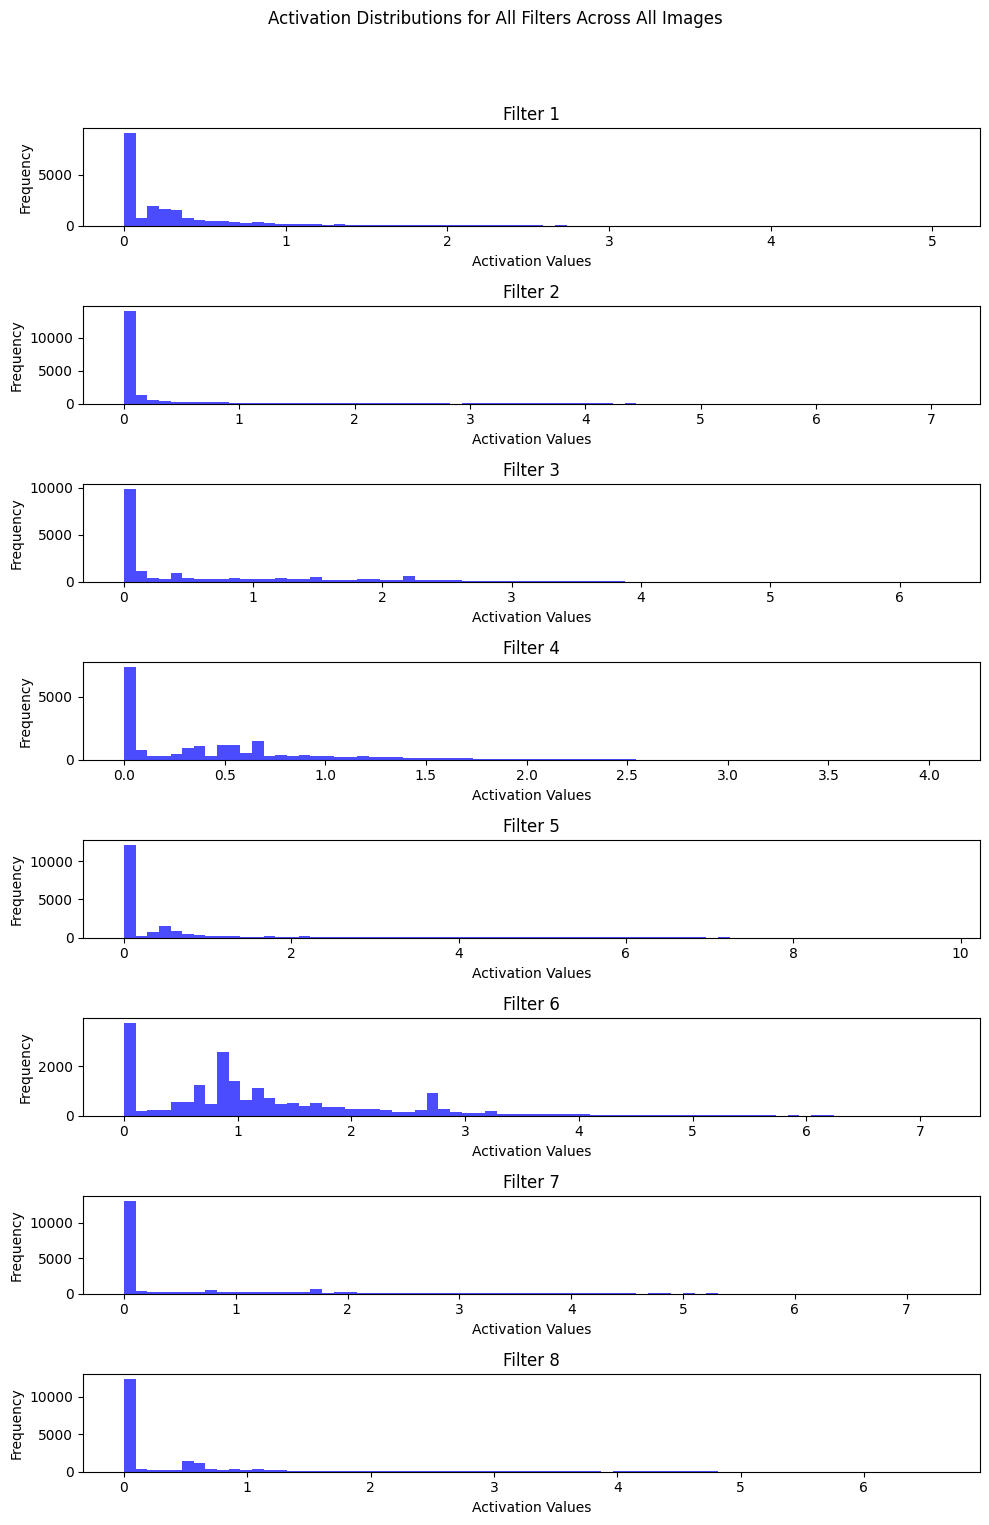

In [ ]:
def plot_activation_histograms(data_dict):
    num_filters = 8  # Number of filters in the first conv layer
    num_bins = 70   # Number of bins in the histogram

    # Initialize lists to store activations for each filter
    all_activations = [[] for _ in range(num_filters)]

    # Accumulate activations from all images for each filter
    for image_data in data_dict.values():
        for i in range(num_filters):
            activation_key = f'activationmap{i+1}'
            all_activations[i].extend(image_data[activation_key])

    # Create a figure with subplots
    fig, axes = plt.subplots(num_filters, 1, figsize=(10, num_filters * 2))
    fig.suptitle('Activation Distributions for All Filters Across All Images')

    # Plot histograms for each filter
    for i in range(num_filters):
        ax = axes[i] if num_filters > 1 else axes
        ax.hist(all_activations[i], bins=num_bins, color='blue', alpha=0.7)
        ax.set_title(f'Filter {i+1}')
        ax.set_xlabel('Activation Values')
        ax.set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Call the function to plot histograms
plot_activation_histograms(smallDebug_dict)


In this function we implement the binning based on manually identified intervals. We pack activation maps as a sequence of characters together into sequences: These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. In sum, we create a list of jsonl entries suitable for neural network finetuning where the input contains the activation map and the output the descriptions. By this approach I could significantly reduce the sequence length from 20.000 to around 1.000 tokens.

In [ ]:
def map_activation_to_char(activation):
    """Maps an activation value to a character based on predefined intervals."""
    if activation == 0:
        return 'z'
    elif 0 < activation <= 0.6:
        return 'l'
    elif 0.6 < activation <= 1.3:
        return 'm'
    elif 1.3 < activation <= 2.2:
        return 'h'
    else:  # activation > 2.2
        return 'v'

def generate_jsonl_data(data_dict):
    jsonl_data = []

    for image_key, image_data in data_dict.items():
        # Concatenate activation maps
        concatenated_activations = np.concatenate(
            [image_data[f'activationmap{j+1}'] for j in range(8)]
        )
        input_sequence = 'f'
        # Process and append each activation map
        for j in range(8):  # Assuming 8 filters in the first conv layer
            activation_map_key = f'activationmap{j+1}'
            mapped_activations = ''.join(map(map_activation_to_char, image_data[activation_map_key]))
            input_sequence += mapped_activations + 'f'  # Append 'f' after each activation map

        # Remove the last 'f' appended
        input_sequence = input_sequence[:-1]

        # Retrieve the image description and we need it to unpack from the tuple
        output_description = image_data['image_description']
        output_description = output_description[0]

        # Create a JSONL-like entry
        jsonl_data.append({
            "input": input_sequence,
            "output": output_description
        })


    return jsonl_data


For illustration and debugging we look at the jsonl data again.  

In [ ]:
# General overview of our synthetic data for first inspection:
debugJSONL_dataDig = create_data_dict(targetCNN, num_images=100)
debubjsonl_data = generate_jsonl_data(debugJSONL_dataDig)

# Print information for debugging Purposes
# General overview of the data structure and content
print("\nGeneral Data Overview:")
print(f"Total number of entries: {len(debubjsonl_data)}")

entry_index = 2
specific_entry = debubjsonl_data[entry_index]
print(f"Number of entries in entry a specific entry : {len(debubjsonl_data[entry_index])}")
print(f"Analysing specific entry number {entry_index}")
print(f"Input Length is 14 x 14 x 8 + 8 (for prepending each activation with an f): {len(specific_entry['input'])}")
print(f"Output: {specific_entry['output']} \n\n")
print(specific_entry)


entry_index = 199
specific_entry = debubjsonl_data[entry_index]
print(f"Number of entries in entry a specific entry : {len(debubjsonl_data[entry_index])}")
print(f"Analysing specific entry number {entry_index}")
print(f"Input Length is 14 x 14 x 8 + 8 (for prepending each activation with an f): {len(specific_entry['input'])}")
print(f"Output: {specific_entry['output']} \n\n")
print(specific_entry)


General Data Overview:
Total number of entries: 200
Number of entries in entry a specific entry : 2
Analysing specific entry number 2
Input Length is 14 x 14 x 8 + 8 (for prepending each activation with an f): 1576
Output: Image with 2 shapes: 1 corner, 1 horizontal 


{'input': 'fzlzzzzzzzzzzzlllzzzzzzzzzzllllzzzzzzzzzzzlllzzzzzzzzzzzlllzzzzzzzzzzzlllzzzzzzzzzzzlllzzzlzzzzzzzlllzzzlzlllzzzlllzzzllmmmlzzlllzzzlmmmlzzzlllzzlmmllzzzzlllzzzllhmhmhhhzzzzzzzzzzzzzzllzzlhmlllllmhfzzzzzzzzzzzzzzzzzzzzzzzzzzzlzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzlzzzzllzzzzzzzzzzzzllzzzzzlzlzlzzllzzzzzzhhhllzllzzzzzmlhmmzzllzzzzlzzzzzzzzlzzzzzzmhvvvvvmzzzzzzzzzzzzzzfzzzzzzzzzzzzzzzzzzzzzzzzzzlzzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzzzzzzzzllzzzzzlllzmzzllzzzzzlllmmlzllzzzzzmmlmlzzllzzzzzlzlmmmmhlzzzzlhhzlmhhhhlmhhhhvvvhhvvvmhvvvvhvvhhhhmfmmllllllllllmmllllllllllllmmmlzzzzzzzzzzllmlzzzzzzzzzzllmlzzzzzzzzzzllmlzzzzzzzzzzllmlzzzzzzllzzllmlzzzllzzlzzllmlzzzlmzzmlzll

I claimed, that binning reduced the token length by 95 % so that we end up with context windows of around 1.000 tokens. To prove this claim, we get generate a dataset using our char-encoding scheme from above and use the mistral-7b tokenizer to create the sequence on which we perform the autoregressive training. Then we visualize the lenghts. Afterwards, we define a maximum length for all sequences and pad shorter sequences so that we have fixed lengths input vectors to fine-tune our large language model.

In [ ]:
# Create a production ready data set:
debug3DataDict = create_data_dict(targetCNN, num_images=100)
debug3jsonl_data = generate_jsonl_data(debug3DataDict)

# Step 1: Write your JSONL data to a file
jsonl_file_path = 'debugTrainingSet.jsonl'
with open(jsonl_file_path, 'w') as f:
    for entry in debug3jsonl_data:
        json.dump(entry, f)
        f.write('\n')

debug3_trainingdataset = load_dataset('json', data_files=jsonl_file_path, split='train')


# Manually split the dataset to ensure that the humanly annotated data remains in the dataset
validation_size = int(0.1 * len(debug3_trainingdataset))  # 10% for validation
train_indices = list(range(validation_size, len(debug3_trainingdataset)))
val_indices = list(range(validation_size))

# Use Dataset.select() to split the dataset
debugtrain_dataset = debug3_trainingdataset.select(train_indices)
debugeval_dataset = debug3_trainingdataset.select(val_indices)

print(f"The training set contains {len(debugtrain_dataset)} instances.")
print(f"The evaluation set contains {len(debugeval_dataset)} instances.")

# Calculate the index of the first human-annotated instance in the training set
# Since the last 100 instances are human-annotated, we subtract 100 from the total length
second_human_annotated_index = len(debugtrain_dataset) - 99

# Retrieve and print the first human-annotated instance from the training set
second_human_annotated_instance = debugtrain_dataset[second_human_annotated_index]
print("Second Human Annotated Instance in Training Set:")
print(second_human_annotated_instance)

# Retrieve and print the first instance from the validation set
first_validation_instance = debugeval_dataset[0]
print("\nFirst Instance in Validation Set:")
print(first_validation_instance)


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

The training set contains 180 instances.
The evaluation set contains 20 instances.
Second Human Annotated Instance in Training Set:
{'input': 'fzlllzzmlllzzzllllzlvhhlllzllllzhvvlzllzzzlllmhmzzhmmlzzlllllzzhmzllzzlllllzlhllllzzllllzzhhzlzzzzllllzmhzlllzzzlllzmmzzzzzzlmhllzmllhhhhhvvhlllmlmmmmmmlzzlllmzzlllzzlmmzzzzzzzzzzzzzzllzlzlllzzzzlmfzzzzzzzzzzzzzzzzzzzhvvhzzzzlzzzvvvvvhllzllzzmhvhmzzllzllzzzzzzzlmmzzllzzzlzzzlmlzzllzzzzzllmlzzzllzzzzlmmmzzzzllzzlmmmmzzzzzzzzzlmhmlzzmvvvvzzlmvvvvvvvvvvzzlllmmmmmzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzzfzzzzlmmzzzzzzzzzmhhhvvhhmzlzzzmhlhvvhhmzllzzlzzzzzzzzzllzzzzzmzzlzzzllzzllhhzllzzzllzzzhhmllzzzzllzzmhhzmzzzzlmlzzmhlhvhvvvvvhzzmmmvvhvvvhhhzzzzzzllmmmmvmzzzzzzzzzzzzzzlmhhhhhmmmmmhhmhvvvvvvvvvvvhfmmlllzzzmhmlmmlllzzzlzzlmlmmmllhmvlzmmzzllmlhhlmlzhvlzllmlmzzmmlmmlzllmlzllzllzmlzllmlzzmzmllmlzllmllllzmlmmzzlmmllhzzzzlzzzzmmlhhzzzzzzzzlmmlhmlmhhhhhlmmmlmhmmhhhmzzmmzzzzzzzzzlllmmzzzzzzzzzzzzzzflzzzzhvvhzzzzzmzzzhvvhvlzzzzlzzzvvzvvlzzzzlzzzhmzvvzzzzzlzzzlzvvvzzz

We use this function to prepend a prompt to the input output pair so that the large language model understands its task better. Unfortunately, this prompt adds to the token count of the sequence.

In [ ]:
def formatting_func(trainingInstance):
    text = f"""You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shapes, such as corners, edges, ellipses, crossings, checkerboard pattern, horizontals, verticals, etc. ### Input: {trainingInstance['input']} \n ### Output: {trainingInstance['output']}"""
    return text

We need the Mistral-7B-v0.1 tokenizer because that is the tokenizer for our neural network.

Here we load and initialize the the tokenizer.

In [ ]:
base_model_id = "mistralai/Mistral-7B-v0.1"

tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Here we plot the lengths of the input tokens. To be honest, 1,240 is still a big context length for our 7b model even though the model was pretrained with a max-context size of about 8,000 tokens. I am confident, that this experiment, rerun with its successor, Mistral 8x7b would yield much better results.

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

200


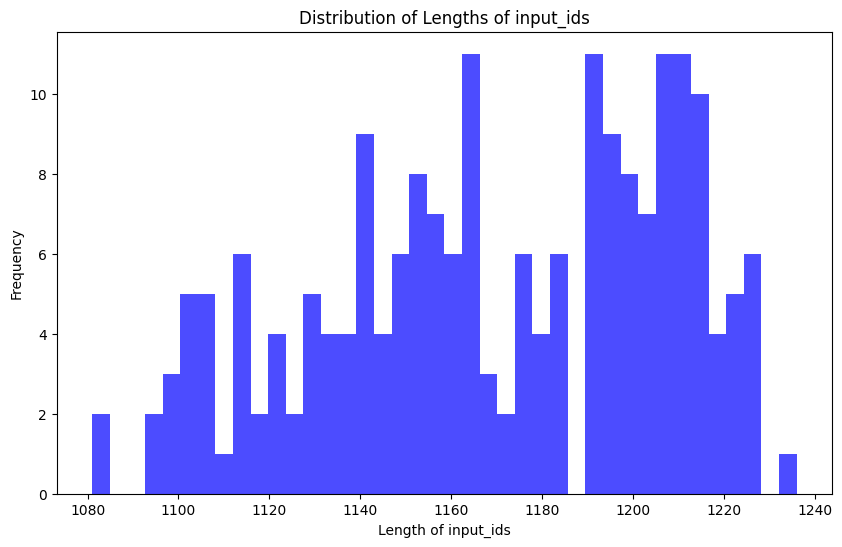

In [ ]:
debugtokenized_train_dataset = debugtrain_dataset.map(generate_and_tokenize_prompt)
debugtokenized_val_dataset = debugeval_dataset.map(generate_and_tokenize_prompt)


def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in debugtokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in debugtokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=40, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(debugtokenized_train_dataset, debugtokenized_val_dataset)


For illustration, we pick a random sequence of the tokenized dataset, decode it and then print it, so that we ensure that tokenization and detokenization work as expected and also we can peek at a full sequence of our dataset.

In [ ]:
def detokenize_random_input(tokenized_dataset, tokenizer):
    # Choose a random entry from the dataset
    random_entry = random.choice(tokenized_dataset)

    # Extract input_ids
    input_ids = random_entry['input_ids']
    # Detokenize the input_ids
    detokenized_sequence = tokenizer.decode(input_ids)

    return detokenized_sequence

random_train_sequence = detokenize_random_input(debugtokenized_train_dataset, tokenizer)

print("Random Training Sequence:")
print(random_train_sequence)


Random Training Sequence:
<s> You will be presented with sequences of characters representing features of images, which could be basic geometric structures or elements similar to MNIST handwritten digits. These sequences are encoded representations of the image's activation maps, derived from the first layer of a convolutional neural network. The character 'f' marks the beginning of a new filter's activation map of the first layer. The characters 'z', 'l', 'm', 'h', and 'v', indicate varying levels of activation: zero, low, medium, high, and very high, respectively. Your task is to understand the patterns in the sequence and to interpret these sequences to determine the number and types of shapes present in the image. The desired output format should be 'output: Image with [number of shapes] shapes: [number of first shape] [name of shape] ... [number of last shape] [name of last shape]', where the description includes the types of shapes, such as corners, edges, ellipses, crossings, ch

Since all our sequences are smaller than 1,280 tokens we set the maximum context window to 1,280 tokens so that the large language model has the full information of the activation map when it has the task to predict the shapes. Moreover, we padd all sequences with padding tokens so that they have the same length when we feed these sequences to the transformer.

In [ ]:
max_length = 1280 # This is the appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

Let us tokenize our data with the newly padded scheme.

In [ ]:
debugtokenized_train_dataset = debugtrain_dataset.map(generate_and_tokenize_prompt2)
debugtokenized_val_dataset = debugeval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

Let us plot the tokenized sequences to confirm that they all have the same length now.

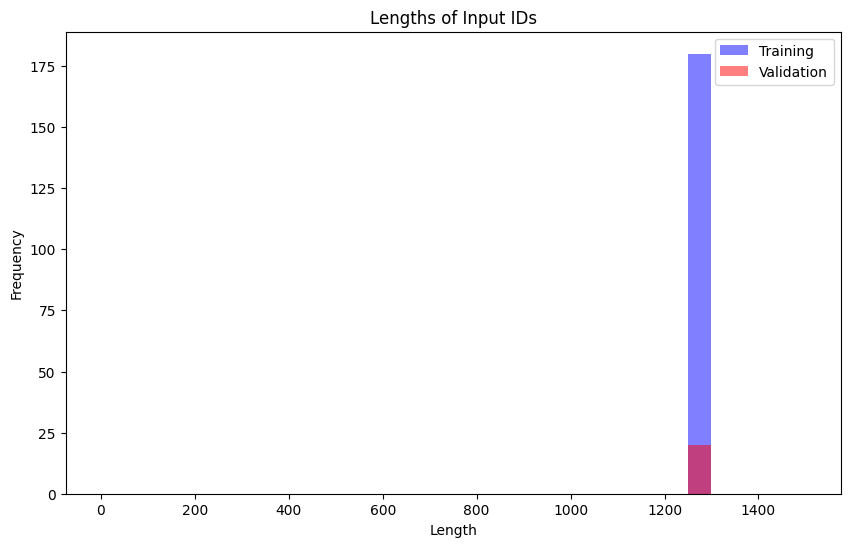

In [ ]:
def plot_input_lengths(tokenized_train_dataset, tokenized_val_dataset, max_length):
    # Extract lengths of input_ids from the datasets
    train_lengths = [len(item['input_ids']) for item in tokenized_train_dataset]
    val_lengths = [len(item['input_ids']) for item in tokenized_val_dataset]

    # Plot histograms
    plt.figure(figsize=(10, 6))

    # Histogram for both datasets
    plt.hist(train_lengths, bins=range(0, max_length + 1, 50), color='blue', alpha=0.5, label='Training')
    plt.hist(val_lengths, bins=range(0, max_length + 1, 50), color='red', alpha=0.5, label='Validation')

    plt.title('Lengths of Input IDs')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Call the function with datasets
plot_input_lengths(debugtokenized_train_dataset, debugtokenized_val_dataset, 1500)



Check that input_ids is padded on the left with the eos_token (2) and there is an eos_token 2 added to the end, and the prompt starts with a bos_token (1).

In [ ]:
print(debugtokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 995, 622, 347, 7567, 395, 22456, 302, 6128, 14030, 4190, 302, 6203, 28725, 690, 829, 347, 6471, 28094, 11294, 442, 5176, 3684, 298, 351, 28759, 8048, 1021, 15957, 3968, 1046, 28723, 2957, 22456, 460, 23174, 23384, 302, 272, 3469, 28742, 28713, 25159, 11745, 28725, 11236, 477, 272, 907, 7487, 302, 264, 4221, 1420, 1479, 25726, 3681, 28723, 415, 3233, 464, 28722, 28742, 14191, 272, 5398, 302, 264, 633, 5531, 28742, 28713, 25159, 3341, 302, 272, 907, 7487, 28723, 415, 6128

Great, we did a lot of debugging but actually now we are shure of our data set and we can make a really big data set and train our neural network interpreter on it:

In [ ]:
# Create a production ready data set of 15,000 images:
realdataDict = create_data_dict(targetCNN, num_images=15000)
realjsonl_data = generate_jsonl_data(realdataDict)

# Step 1: Write JSONL data to a file
jsonl_file_pathReal = 'realtrainingSet.jsonl'
with open(jsonl_file_pathReal, 'w') as f:
    for entry in realjsonl_data:
        json.dump(entry, f)
        f.write('\n')

real_trainingdataset = load_dataset('json', data_files=jsonl_file_pathReal, split='train')

# Manually split the dataset to ensure that the humanly annotated data remains in the dataset
validation_size = int(0.1 * len(real_trainingdataset))  # 10% for validation
train_indices = list(range(validation_size, len(real_trainingdataset)))
val_indices = list(range(validation_size))

# Use Dataset.select() to split the dataset
realtrain_dataset = real_trainingdataset.select(train_indices)
realeval_dataset = real_trainingdataset.select(val_indices)

print(f"The training set contains {len(realtrain_dataset)} instances.")
print(f"The evaluation set contains {len(realeval_dataset)} instances.")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

The training set contains 13590 instances.
The evaluation set contains 1510 instances.


Tokenize again.

In [ ]:
realtokenized_train_dataset = realtrain_dataset.map(generate_and_tokenize_prompt2)
realtokenized_val_dataset = realeval_dataset.map(generate_and_tokenize_prompt2)

# Assuming realtokenized_train_dataset and realtokenized_val_dataset are already defined
train_dataset_size = sys.getsizeof(realtokenized_train_dataset)
val_dataset_size = sys.getsizeof(realtokenized_val_dataset)

print(f"Training dataset memory size: {train_dataset_size} bytes")
print(f"Validation dataset memory size: {val_dataset_size} bytes")


Map:   0%|          | 0/13590 [00:00<?, ? examples/s]

Map:   0%|          | 0/1510 [00:00<?, ? examples/s]

Training dataset memory size: 48 bytes
Validation dataset memory size: 48 bytes


Let us define the device map which we will use to disperse mistral on the 9 GPUs that we use for training.

In [ ]:
# Define the device map
device_map = {
    'model.embed_tokens': 0,
    'model.layers.0': 0, 'model.layers.1': 1, 'model.layers.2': 1, 'model.layers.3': 1,
    'model.layers.4': 1, 'model.layers.5': 2, 'model.layers.6': 2, 'model.layers.7': 2,
    'model.layers.8': 2, 'model.layers.9': 3, 'model.layers.10': 3, 'model.layers.11': 3,
    'model.layers.12': 3, 'model.layers.13': 4, 'model.layers.14': 4, 'model.layers.15': 4,
    'model.layers.16': 4, 'model.layers.17': 5, 'model.layers.18': 5, 'model.layers.19': 5,
    'model.layers.20': 5, 'model.layers.21': 6, 'model.layers.22': 6, 'model.layers.23': 6,
    'model.layers.24': 6, 'model.layers.25': 7, 'model.layers.26': 7, 'model.layers.27': 7,
    'model.layers.28': 7, 'model.layers.29': 8, 'model.layers.30': 8, 'model.layers.31': 8,
    'model.norm': 8,
    'lm_head': 8 # Moving lm_head to GPU 8
}


We initialize mistral for causal language modeling. The model employs 4-bit quantization reducing its memory footprint. The quantization configuration uses a 16-bit floating-point format with its 8-bit exponent and 8-bit mantissa that strikes a balance between precision and computational efficiency (Our A40 GPUs support  `bfloat16` which is not true for many off the shelf-GPUs like T4 on GoogleColab).

In [ ]:
nnInterpreter = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map= device_map,
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_compute_dtype=torch.bfloat16,
        bnb_4bit_quant_type="nf4",
    ),
    torch_dtype=torch.bfloat16,
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Print large language model to understand its structure and also its device map to verify parallel fine-tuning to be fast.

In [ ]:
# Check available GPUs and their names
print(nnInterpreter)

gpu_count = torch.cuda.device_count()
print(f"Available GPUs: {gpu_count}")
for i in range(gpu_count):
    print(f"CUDA:{i} - {torch.cuda.get_device_name(i)}")

nnInterpreter.hf_device_map

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )

{'model.embed_tokens': 0,
 'model.layers.0': 0,
 'model.layers.1': 1,
 'model.layers.2': 1,
 'model.layers.3': 1,
 'model.layers.4': 1,
 'model.layers.5': 2,
 'model.layers.6': 2,
 'model.layers.7': 2,
 'model.layers.8': 2,
 'model.layers.9': 3,
 'model.layers.10': 3,
 'model.layers.11': 3,
 'model.layers.12': 3,
 'model.layers.13': 4,
 'model.layers.14': 4,
 'model.layers.15': 4,
 'model.layers.16': 4,
 'model.layers.17': 5,
 'model.layers.18': 5,
 'model.layers.19': 5,
 'model.layers.20': 5,
 'model.layers.21': 6,
 'model.layers.22': 6,
 'model.layers.23': 6,
 'model.layers.24': 6,
 'model.layers.25': 7,
 'model.layers.26': 7,
 'model.layers.27': 7,
 'model.layers.28': 7,
 'model.layers.29': 8,
 'model.layers.30': 8,
 'model.layers.31': 8,
 'model.norm': 8,
 'lm_head': 8}

Models from the transformers library (as ours) need to be prepared for training such as adapting the datatypes of specific layers when we want to use LorA (more below). This functionality is wrapped in the below function call.

In [ ]:
#nnInterpreter.gradient_checkpointing_enable()
nnInterpreter = prepare_model_for_kbit_training(nnInterpreter)

We use Low-rank adapters for efficient finetuning. These adapters consist of small layers inserted in parallel to attention layers of a pre-trained model. The key idea is to use low-rank matrix factorization, meaning each adapter layer is a product of two smaller matrices, thereby reducing the number of additional parameters required. We use lora adapters for the below listed matrices since this was the recommendation of the lora-paper authors. During training, only the parameters in these adapter layers are updated, while the pre-trained model's original weights remain frozen. This approach allows for rapid adaptation to new tasks without the computational and memory costs of fine-tuning the entire model, making it highly efficient for deploying large-scale models across various tasks. As a result, the optimizer only needs to store first moment (mean) and second moment (variance) information for a very limited set (in our case 2 percent) of trainable parameters. Since maintainin these states is approximately as costing as maintaining all parameters and all gradients together this is extremely significant. (The reader should verify that a 7b parameter model leads to approximately 24gb use of parameters, 24gb use of gradients, and 48 gb use of transformer states with naive finetuning).  

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM",
)

nnInterpreter = get_peft_model(nnInterpreter, config)
print_trainable_parameters(nnInterpreter)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


Lets look at the model again and verify that lora adapters are inserted

In [ ]:
print(nnInterpreter)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralAttention(
              (q_proj): Linear4bit(
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
              )
              (k_proj): Linear4bit(
                (lora_dropout): ModuleDict(

#code

We use a batch size of 4 because because higher batch sizes led to OutOfMemoryErrors and didnt significantly improve efficiency. Gradient accumulation is a technique, where gradients are summed over multiple mini-batches before updating the model parameters. Using two gradient accumulation steps we have an effective batch size of 8 with a memory requirement of a batch size of 4. Learning rate and optimizer are set according to recomendation of the mistral team. We wrap the large language model into a trainer which handles the usage of multiple GPUs for us. We save the model every 200 steps and log the loss and evaluation error also every 200 steps. For fine-tuning we do not need a warm up.

In [ ]:
project = "MNIST-finetune3"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name
bs = 4 #batch size
ga_steps = 2 # gradient accumulation steps
epochs = 3
steps_per_epoch=len(realtokenized_train_dataset)//(bs*ga_steps)

trainer = transformers.Trainer(
    model=nnInterpreter,
    train_dataset= realtokenized_train_dataset,
    eval_dataset= realtokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=1,
        per_device_train_batch_size= bs,
        gradient_accumulation_steps=ga_steps,
        gradient_checkpointing=False,
        learning_rate=0.0002, # Want a small lr for finetuning
        lr_scheduler_type="constant",
        bf16=True,
        num_train_epochs=epochs,
        ddp_find_unused_parameters=False, # instead we use accelerate
        optim="paged_adamw_32bit",
        logging_strategy="steps",
        logging_steps = 200,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy = "steps",
        evaluation_strategy = "steps",
        save_steps= 200,   # Save  every 100
        eval_steps= 200,    # Evaluate every epoch
        do_eval=True,                # Perform evaluation at the end of training
  #     report_to="wandb",
     #   run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)



Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


During initial debugging, I monitored GPU usage to verify that all GPUs were used during training. After debugging this code was not used anymore.


In [ ]:
class MonitorGPU:
    def __init__(self, interval):
        self.interval = interval
        self.thread = threading.Thread(target=self.run)
        self.stop_flag = False

    def run(self):
        while not self.stop_flag:
            print(subprocess.check_output("nvidia-smi", shell=True).decode())
            time.sleep(self.interval)

    def start(self):
        self.thread.start()

    def stop(self):
        self.stop_flag = True
        self.thread.join()  # Wait for the monitoring thread to finish


The output below shows that the large language model is evenly distributed on all A40s.

In [ ]:
print(subprocess.check_output("nvidia-smi", shell=True).decode())

Sun Dec 17 12:00:19 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     Off | 00000000:12:00.0 Off |                    0 |
|  0%   35C    P0              71W / 300W |   1290MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

During debugging and before we start training to convergence we create an instance of the MonitorGPU class so that we can monitor GPU usage during training. This helps in verifying that we use all GPUs. During the actual training run I did not use the class because the Huggingface Trainer instance regularly printed the processed training instances per second which was enough to ensure the training speed for this project.

In [ ]:
monitor = MonitorGPU(interval=30)
#monitor.start()


In [ ]:
# Stop monitoring
#monitor.stop()

For our training configuration, we calculate the total number of iterations based on a dataset of 13,590 instances, a batch size of 4, and no gradient accumulation (2 step). Over 3 epochs, this results in 1,698.75 iterations per epoch, amounting to a total of 5,096.25 iterations for the entire training process. This is displayed below.  


I began the training process and then conducted a second training run, extending it to five epochs, by transferring the code to a Python file for asynchronous execution. However, I observed that training for more than three epochs led to a divergence in the loss. Therefore, I used the Lora-Adapters trained during this run for evaluation. The evaluation process and its outcomes are detailed in a different script.

In [ ]:
nnInterpreter.config.use_cache = False  # silence the warnings.Re-enable for inference!
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/fast/AG_Metzger/lukas/miniconda3/envs/interpreter/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
200,0.649600,0.485940
400,0.436200,0.382696
600,0.369700,0.338850
800,0.334900,0.314154
1000,0.312700,0.291455
1200,0.293400,0.277263
1400,0.271500,0.265217
1600,0.270000,0.254270
1800,0.247800,0.249198
2000,0.238800,0.243652


/fast/AG_Metzger/lukas/miniconda3/envs/interpreter/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/fast/AG_Metzger/lukas/miniconda3/envs/interpreter/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/fast/AG_M

After training we should kill the current process to avoid memory issues and load the model again. Only the QLoRA adapters are saved so when we want to use our trained interpreter we load a clean moddel from the Huggingface Hub.